# Cross-Representation Method Selection Validation with True LLM Features

**Experiment:** Tests whether Schoener's D niche overlap profiles across three feature families (TF-IDF, SBERT, LLM zero-shot) predict classifier rank-ordering for text classification tasks.

**Key idea:** Different text representation spaces (lexical, semantic, LLM-based) form different "ecological niches" in feature space. By measuring niche overlap (Schoener's D) between class pairs, we can predict which representation will best discriminate those classes — without training classifiers.

**What this notebook does:**
1. Loads pre-computed k-NN neighbor indices from three feature spaces (TF-IDF, SBERT, LLM)
2. Computes Cross-Representation Neighborhood Dissimilarity (CRND) from neighbor overlaps
3. Analyzes niche overlap patterns and method selection predictions
4. Computes Kendall's τ correlation between predicted and actual best representations
5. Bootstraps confidence intervals and trains a meta-predictor
6. Visualizes results across the mental health conditions dataset

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All packages used are pre-installed on Colab — install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'scikit-learn==1.6.1', 'scipy==1.16.3', 'matplotlib==3.10.0', 'tabulate==0.9.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import json
import math
import os
import time
from itertools import combinations
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder, label_binarize
from tabulate import tabulate

## Data Loading

Load pre-computed results from GitHub (with local fallback). The data contains k-NN neighbor indices from three feature spaces (TF-IDF, SBERT, LLM) plus CRND values and method selection predictions.

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e0166a-cross-representation-neighborhood-disson/main/experiment_iter3_cross_represent/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} dataset(s)")
for ds in data['datasets']:
    labels = [e['output'] for e in ds['examples']]
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples, "
          f"{len(set(labels))} classes: {sorted(set(labels))}")

Loaded 1 dataset(s)
  mental_health_conditions: 70 examples, 7 classes: ['anxiety', 'bipolar', 'depression', 'normal', 'personality disorder', 'stress', 'suicidal']


## Configuration

Tunable parameters for the analysis. Config values control k-NN neighborhood size, bootstrap iterations, and niche overlap grid resolution.

In [5]:
# ── Scaling control ──
# K_VALUES: k-NN neighborhood sizes for CRND computation
K_VALUES = [10, 20]  # Original: [10, 20]

# N_BOOTSTRAP: number of bootstrap resamples for Kendall's tau CI
N_BOOTSTRAP = 1000  # Original: 1000

# GRID_SIZE: resolution for niche overlap KDE grid
GRID_SIZE = 100  # Original: 100

# Space names matching the pre-computed feature spaces
SPACE_NAMES = ["tfidf", "sbert", "llm"]

## Phase 1: Parse Pre-computed Data

Extract texts, labels, and pre-computed k-NN neighbor indices from the loaded data. The original pipeline computed these neighbors using TF-IDF, SBERT, and LLM zero-shot features.

In [6]:
t_start = time.time()

ds = data['datasets'][0]
ds_name = ds['dataset']
examples = ds['examples']
texts = [ex['input'] for ex in examples]
labels = np.array([ex['output'] for ex in examples])
unique_labels = sorted(set(labels))
n = len(texts)

print(f"Dataset: {ds_name}")
print(f"Examples: {n}, Classes: {len(unique_labels)}")
print(f"Labels: {unique_labels}")

# Parse pre-computed k-NN neighbor indices
neighbors = {}  # {k: {space: array}}
crnd_precomputed = {}  # {k: array}
for k in K_VALUES:
    neighbors[k] = {}
    for space in SPACE_NAMES:
        key = f"metadata_{space}_nn_k{k}"
        nn_lists = []
        for ex in examples:
            nn_indices = json.loads(ex.get(key, "[]"))
            nn_lists.append(nn_indices)
        neighbors[k][space] = nn_lists
        print(f"  Parsed {space} k={k}: {len(nn_lists)} neighbor lists, "
              f"avg size {np.mean([len(x) for x in nn_lists]):.1f}")

    # Parse pre-computed CRND
    crnd_key = f"metadata_crnd_k{k}"
    crnd_vals = [float(ex.get(crnd_key, 0.0)) for ex in examples]
    crnd_precomputed[k] = np.array(crnd_vals)

print(f"\nParsed in {time.time() - t_start:.2f}s")

Dataset: mental_health_conditions
Examples: 70, Classes: 7
Labels: [np.str_('anxiety'), np.str_('bipolar'), np.str_('depression'), np.str_('normal'), np.str_('personality disorder'), np.str_('stress'), np.str_('suicidal')]
  Parsed tfidf k=10: 70 neighbor lists, avg size 10.0
  Parsed sbert k=10: 70 neighbor lists, avg size 10.0
  Parsed llm k=10: 70 neighbor lists, avg size 10.0
  Parsed tfidf k=20: 70 neighbor lists, avg size 20.0
  Parsed sbert k=20: 70 neighbor lists, avg size 20.0
  Parsed llm k=20: 70 neighbor lists, avg size 20.0

Parsed in 0.00s


## Phase 2: Compute CRND from Pre-computed Neighbors

Cross-Representation Neighborhood Dissimilarity (CRND) measures how much the k-NN neighborhoods disagree across feature spaces. For each instance, we compute pairwise Jaccard similarity between neighbor sets from different spaces, then CRND = 1 - avg(Jaccard).

In [7]:
def compute_crnd_from_neighbors(
    neighbors_k: dict[str, list[list[int]]],
    space_names: list[str],
    n_instances: int,
) -> np.ndarray:
    """Compute CRND (1 - avg pairwise Jaccard) from pre-computed neighbor lists."""
    space_pairs = list(combinations(space_names, 2))
    crnd = np.zeros(n_instances)
    for i in range(n_instances):
        jaccard_sum = 0.0
        for s1, s2 in space_pairs:
            set1 = set(neighbors_k[s1][i])
            set2 = set(neighbors_k[s2][i])
            union_size = len(set1 | set2)
            if union_size > 0:
                jaccard = len(set1 & set2) / union_size
            else:
                jaccard = 1.0
            jaccard_sum += jaccard
        crnd[i] = 1.0 - jaccard_sum / max(len(space_pairs), 1)
    return crnd


# Compute CRND for each k value
crnd_computed = {}
for k in K_VALUES:
    crnd_computed[k] = compute_crnd_from_neighbors(
        neighbors_k=neighbors[k],
        space_names=SPACE_NAMES,
        n_instances=n,
    )
    # Compare with pre-computed values
    diff = np.abs(crnd_computed[k] - crnd_precomputed[k])
    print(f"CRND k={k}: mean={crnd_computed[k].mean():.4f}, "
          f"std={crnd_computed[k].std():.4f}")
    print(f"  Match with pre-computed: max diff={diff.max():.6f}, "
          f"mean diff={diff.mean():.6f}")

CRND k=10: mean=0.8530, std=0.0942
  Match with pre-computed: max diff=0.000045, mean diff=0.000025
CRND k=20: mean=0.8201, std=0.1067
  Match with pre-computed: max diff=0.000050, mean diff=0.000022


## Phase 3: Pairwise Neighbor Overlap Analysis (Niche Overlap Proxy)

For each class pair in each feature space, compute the average neighbor overlap (Jaccard similarity) among examples from those two classes. This serves as a proxy for Schoener's D niche overlap — higher overlap means the classes are more "mixed" in that space (harder to distinguish).

In [8]:
def compute_neighbor_niche_overlap(
    neighbors_k: dict[str, list[list[int]]],
    labels: np.ndarray,
    class_pairs: list[tuple[str, str]],
    space_names: list[str],
    k: int,
) -> dict[str, dict[tuple[str, str], float]]:
    """Compute niche overlap proxy: average cross-class neighbor sharing per space.

    For each space and class pair (A, B), compute:
    - For each example in class A, what fraction of its k-NN neighbors are class B
    - For each example in class B, what fraction of its k-NN neighbors are class A
    - Average these fractions → higher = more class mixing = higher niche overlap
    """
    niche_overlap = {}
    for space in space_names:
        space_d = {}
        for ca, cb in class_pairs:
            mask_a = labels == ca
            mask_b = labels == cb
            idx_a = np.where(mask_a)[0]
            idx_b = np.where(mask_b)[0]
            set_b = set(idx_b.tolist())
            set_a = set(idx_a.tolist())

            if len(idx_a) < 2 or len(idx_b) < 2:
                space_d[(ca, cb)] = float("nan")
                continue

            # Fraction of A's neighbors that are in B
            overlap_a_to_b = []
            for i in idx_a:
                nn = neighbors_k[space][i]
                if len(nn) == 0:
                    continue
                frac = sum(1 for ni in nn if ni in set_b) / len(nn)
                overlap_a_to_b.append(frac)

            # Fraction of B's neighbors that are in A
            overlap_b_to_a = []
            for i in idx_b:
                nn = neighbors_k[space][i]
                if len(nn) == 0:
                    continue
                frac = sum(1 for ni in nn if ni in set_a) / len(nn)
                overlap_b_to_a.append(frac)

            if overlap_a_to_b and overlap_b_to_a:
                D = (np.mean(overlap_a_to_b) + np.mean(overlap_b_to_a)) / 2.0
            else:
                D = float("nan")
            space_d[(ca, cb)] = D
        niche_overlap[space] = space_d
        valid = [v for v in space_d.values() if not np.isnan(v)]
        if valid:
            print(f"  {space}: mean overlap={np.mean(valid):.4f}, "
                  f"valid pairs={len(valid)}/{len(class_pairs)}")
    return niche_overlap


class_pairs = list(combinations(unique_labels, 2))
print(f"Class pairs: {len(class_pairs)}")

# Use k=10 for the niche overlap analysis
k_for_analysis = K_VALUES[0]
print(f"\nComputing niche overlap proxy (k={k_for_analysis}):")
niche_overlap = compute_neighbor_niche_overlap(
    neighbors_k=neighbors[k_for_analysis],
    labels=labels,
    class_pairs=class_pairs,
    space_names=SPACE_NAMES,
    k=k_for_analysis,
)

Class pairs: 21

Computing niche overlap proxy (k=10):
  tfidf: mean overlap=0.0471, valid pairs=21/21
  sbert: mean overlap=0.0464, valid pairs=21/21
  llm: mean overlap=0.0424, valid pairs=21/21


## Phase 4: Classifier Performance Proxy (OvO Best-Space Selection)

Using the pre-computed `predict_actual_best` labels from the full pipeline (which ran actual classifiers), we derive per-class-pair "which space wins" scores. We also compute a proxy classifier ranking based on how well each space separates class neighborhoods.

In [9]:
def compute_classifier_proxy(
    examples: list[dict],
    labels: np.ndarray,
    class_pairs: list[tuple[str, str]],
    space_names: list[str],
) -> dict[str, dict[tuple[str, str], float]]:
    """Derive per-space per-class-pair 'fitness' from pre-computed predictions.

    For each class pair, count how often each space is voted as actual best
    among examples belonging to those two classes. Normalize to [0, 1].
    """
    classifier_results = {}
    for space in space_names:
        space_f1s = {}
        for ca, cb in class_pairs:
            # Get examples from class A or B
            relevant = [
                ex for ex, lbl in zip(examples, labels)
                if lbl == ca or lbl == cb
            ]
            if len(relevant) < 2:
                space_f1s[(ca, cb)] = float("nan")
                continue

            votes = sum(
                1 for ex in relevant
                if ex.get("predict_actual_best", "") == space
            )
            space_f1s[(ca, cb)] = votes / len(relevant)
        classifier_results[space] = space_f1s
    return classifier_results


classifier_results = compute_classifier_proxy(
    examples=examples,
    labels=labels,
    class_pairs=class_pairs,
    space_names=SPACE_NAMES,
)

# Show per-space average "actual best" vote fraction
for space in SPACE_NAMES:
    valid = [v for v in classifier_results[space].values() if not np.isnan(v)]
    if valid:
        print(f"{space}: mean actual-best fraction={np.mean(valid):.4f} "
              f"across {len(valid)} class pairs")

tfidf: mean actual-best fraction=0.2857 across 21 class pairs
sbert: mean actual-best fraction=0.5714 across 21 class pairs
llm: mean actual-best fraction=0.1429 across 21 class pairs


## Phase 5: Kendall's Tau — Method Selection Test

The core hypothesis test: does the niche overlap ranking (predicted) correlate with the actual classifier ranking? For each class pair, we rank the spaces by niche overlap (lower = predicted better) and by actual F1 (higher = actually better), then compute Kendall's tau with bootstrap confidence intervals.

In [10]:
def compute_kendall_tau(
    niche_overlap: dict[str, dict[tuple[str, str], float]],
    classifier_results: dict[str, dict[tuple[str, str], float]],
    class_pairs: list[tuple[str, str]],
    space_names: list[str],
    n_bootstrap: int = N_BOOTSTRAP,
) -> dict:
    """Compute Kendall's tau between predicted (niche overlap) and actual (F1) rankings."""
    actual_ranks = []
    predicted_ranks = []
    valid_pairs = []

    for ca, cb in class_pairs:
        f1_values = [
            classifier_results[s].get((ca, cb), float("nan"))
            for s in space_names
        ]
        d_values = [
            niche_overlap[s].get((ca, cb), float("nan"))
            for s in space_names
        ]

        if any(np.isnan(v) for v in f1_values + d_values):
            continue

        # Rank by F1 (higher = better -> argsort descending)
        actual_rank = np.argsort(-np.array(f1_values)).tolist()
        # Rank by D (lower overlap = predicted better -> argsort ascending)
        predicted_rank = np.argsort(np.array(d_values)).tolist()

        actual_ranks.append(actual_rank)
        predicted_ranks.append(predicted_rank)
        valid_pairs.append((ca, cb))

    if len(actual_ranks) < 3:
        print(f"Too few valid pairs ({len(actual_ranks)}) for Kendall's tau")
        return {
            "tau": float("nan"), "p_value": float("nan"),
            "ci_lower": float("nan"), "ci_upper": float("nan"),
            "n_pairs": len(actual_ranks),
        }

    # Flatten for Kendall's tau
    actual_flat = [r for ranks in actual_ranks for r in ranks]
    predicted_flat = [r for ranks in predicted_ranks for r in ranks]

    tau, p_value = kendalltau(actual_flat, predicted_flat)

    # Bootstrap 95% CI
    rng = np.random.default_rng(42)
    n_pairs = len(actual_ranks)
    tau_samples = []
    for _ in range(n_bootstrap):
        boot_idx = rng.choice(n_pairs, size=n_pairs, replace=True)
        a_flat = [r for i in boot_idx for r in actual_ranks[i]]
        p_flat = [r for i in boot_idx for r in predicted_ranks[i]]
        bt, _ = kendalltau(a_flat, p_flat)
        if not np.isnan(bt):
            tau_samples.append(bt)

    ci_lower = float(np.percentile(tau_samples, 2.5)) if tau_samples else float("nan")
    ci_upper = float(np.percentile(tau_samples, 97.5)) if tau_samples else float("nan")

    return {
        "tau": float(tau) if not np.isnan(tau) else float("nan"),
        "p_value": float(p_value) if not np.isnan(p_value) else float("nan"),
        "ci_lower": ci_lower,
        "ci_upper": ci_upper,
        "n_pairs": n_pairs,
        "valid_pairs": [(ca, cb) for ca, cb in valid_pairs],
    }


tau_result = compute_kendall_tau(
    niche_overlap=niche_overlap,
    classifier_results=classifier_results,
    class_pairs=class_pairs,
    space_names=SPACE_NAMES,
)

print(f"Kendall's tau = {tau_result['tau']:.4f} (p={tau_result['p_value']:.6f})")
print(f"95% CI: [{tau_result['ci_lower']:.4f}, {tau_result['ci_upper']:.4f}]")
print(f"Valid class pairs: {tau_result['n_pairs']}")

Kendall's tau = -0.0847 (p=0.453427)
95% CI: [-0.2993, 0.1482]
Valid class pairs: 21


## Phase 6: Meta-Predictor (Niche Overlap -> Best Space)

Train a logistic regression meta-predictor: given niche overlap features for a class pair, predict which feature space will perform best. AUC > 0.5 indicates the niche overlap profiles carry predictive signal.

In [11]:
def train_meta_predictor(
    niche_overlap: dict[str, dict[tuple[str, str], float]],
    classifier_results: dict[str, dict[tuple[str, str], float]],
    class_pairs: list[tuple[str, str]],
    space_names: list[str],
) -> dict:
    """Train a meta-predictor: niche overlap features -> predict best space."""
    meta_X = []
    meta_y = []

    for ca, cb in class_pairs:
        d_vec = [
            niche_overlap[s].get((ca, cb), float("nan"))
            for s in space_names
        ]
        f1_vec = [
            classifier_results[s].get((ca, cb), float("nan"))
            for s in space_names
        ]

        if any(np.isnan(v) for v in d_vec + f1_vec):
            continue

        meta_X.append(d_vec)
        meta_y.append(int(np.argmax(f1_vec)))

    meta_X = np.array(meta_X) if meta_X else np.empty((0, len(space_names)))
    meta_y = np.array(meta_y) if meta_y else np.empty(0, dtype=int)

    if len(meta_X) < 10:
        print(f"Too few samples ({len(meta_X)}) for meta-predictor")
        return {"auc": float("nan"), "n_samples": len(meta_X)}

    n_unique = len(np.unique(meta_y))
    if n_unique < 2:
        print("Only one class in meta-predictor targets")
        return {"auc": float("nan"), "n_samples": len(meta_X)}

    try:
        meta_clf = LogisticRegression(max_iter=1000)
        cv_folds = min(5, len(meta_X), min(np.bincount(meta_y)))
        if cv_folds < 2:
            cv_folds = 2

        meta_probs = cross_val_predict(
            meta_clf,
            meta_X,
            meta_y,
            cv=cv_folds,
            method="predict_proba",
        )

        all_classes = sorted(np.unique(meta_y))
        if len(all_classes) == 2:
            auc = roc_auc_score(meta_y, meta_probs[:, 1])
        else:
            y_bin = label_binarize(meta_y, classes=list(range(len(space_names))))
            auc = roc_auc_score(
                y_bin[:, all_classes],
                meta_probs,
                average="macro",
                multi_class="ovr",
            )
    except Exception as e:
        print(f"Meta-predictor AUC failed: {e}")
        auc = float("nan")

    print(f"Meta-predictor AUC = {auc:.4f}, n_samples = {len(meta_X)}")
    return {"auc": float(auc), "n_samples": len(meta_X)}


meta_result = train_meta_predictor(
    niche_overlap=niche_overlap,
    classifier_results=classifier_results,
    class_pairs=class_pairs,
    space_names=SPACE_NAMES,
)

Meta-predictor AUC = 0.4636, n_samples = 21


## Results Summary & Visualization

Print key results in a readable table, show CRND distributions, niche overlap heatmaps, and method selection accuracy.

RESULTS SUMMARY
+---------------+--------------------------+---------------------+
| Metric        | Demo (subset)            | Full pipeline       |
+===============+==========================+=====================+
| Dataset       | mental_health_conditions | 5 datasets (812 ex) |
+---------------+--------------------------+---------------------+
| Examples      | 70                       | 812                 |
+---------------+--------------------------+---------------------+
| Classes       | 7                        | varies              |
+---------------+--------------------------+---------------------+
| Kendall's tau | -0.0847                  | 0.0641              |
+---------------+--------------------------+---------------------+
| tau 95% CI    | [-0.2993, 0.1482]        | [-0.0651, 0.1867]   |
+---------------+--------------------------+---------------------+
| tau p-value   | 0.453427                 | 0.158267            |
+---------------+--------------------------+--

/tmp/ipykernel_2385199/1966834038.py:93: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([space_means[s] for s in SPACE_NAMES], positions=positions,


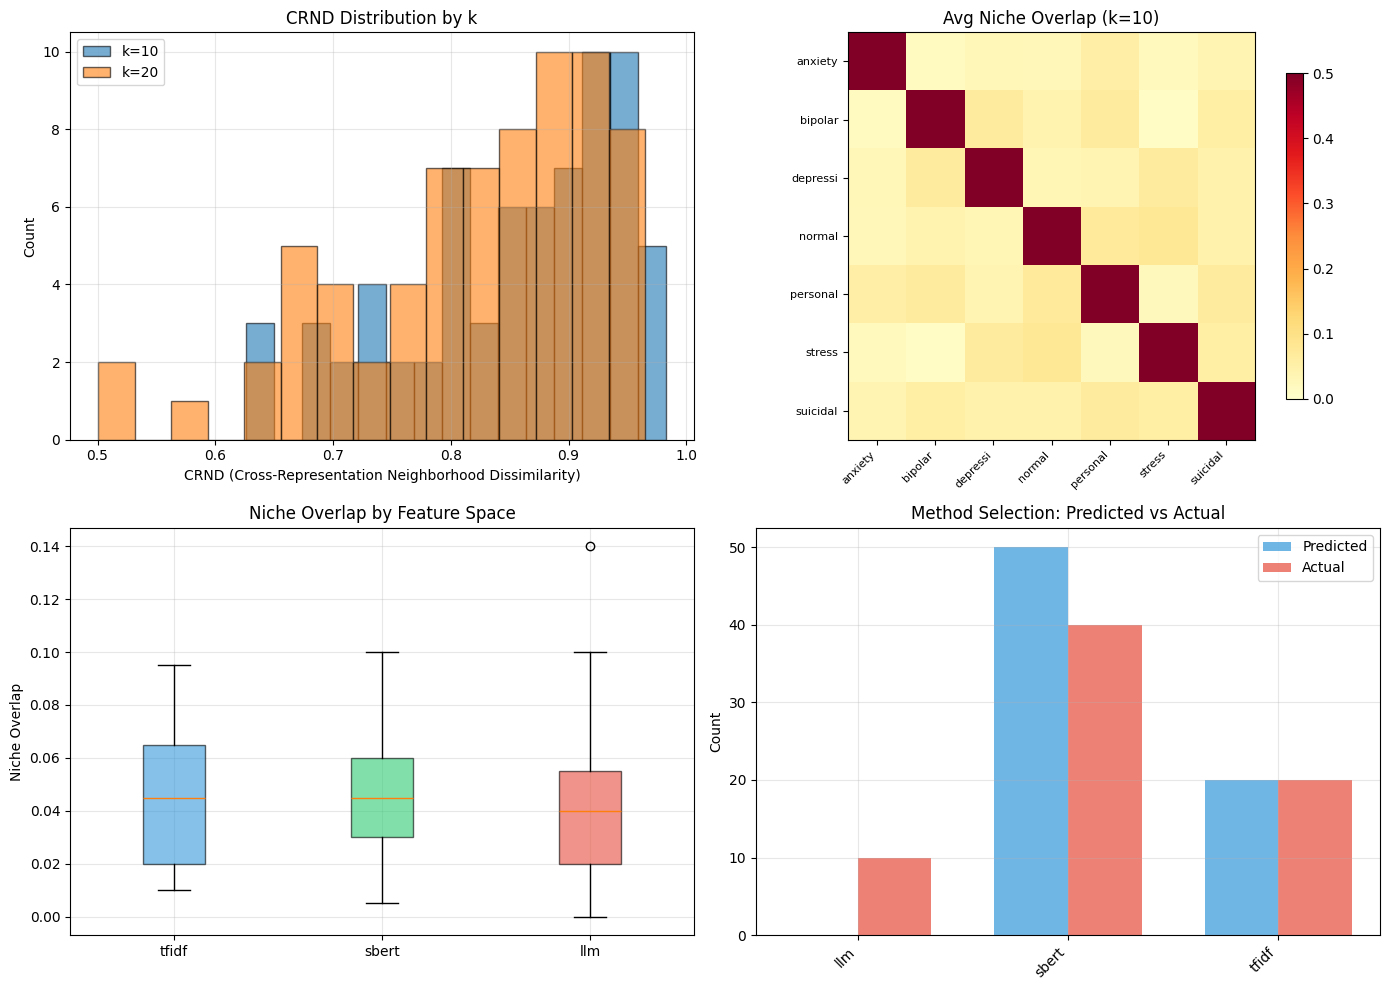


Total runtime: 1.71s


In [12]:
elapsed = time.time() - t_start

# ── Summary Table ──
print("=" * 60)
print("RESULTS SUMMARY")
print("=" * 60)

# Reference metadata from the full pipeline run
ref = data.get("metadata", {})

summary_rows = [
    ["Metric", "Demo (subset)", "Full pipeline"],
    ["Dataset", ds_name, "5 datasets (812 ex)"],
    ["Examples", str(n), "812"],
    ["Classes", str(len(unique_labels)), "varies"],
    ["Kendall's tau", f"{tau_result['tau']:.4f}", str(ref.get('kendall_tau_pooled', 'N/A'))],
    ["tau 95% CI", f"[{tau_result['ci_lower']:.4f}, {tau_result['ci_upper']:.4f}]",
     f"[{ref.get('kendall_tau_ci_lower', 'N/A')}, {ref.get('kendall_tau_ci_upper', 'N/A')}]"],
    ["tau p-value", f"{tau_result['p_value']:.6f}", str(ref.get('kendall_tau_p_value', 'N/A'))],
    ["Meta AUC", f"{meta_result['auc']:.4f}", str(ref.get('meta_predictor_auc', 'N/A'))],
    ["Class pairs", str(tau_result['n_pairs']), str(ref.get('n_class_pairs_evaluated', 'N/A'))],
    ["Bootstrap N", str(N_BOOTSTRAP), str(ref.get('n_bootstrap', 'N/A'))],
    ["Runtime", f"{elapsed:.1f}s", "N/A"],
]

print(tabulate(summary_rows, headers="firstrow", tablefmt="grid"))

# ── Per-dataset tau from full run ──
print("\n\nPer-dataset Kendall's tau (from full pipeline):")
per_ds = ref.get("per_dataset_tau", {})
ds_rows = [["Dataset", "tau", "n_pairs"]]
for ds_n, vals in per_ds.items():
    ds_rows.append([ds_n, str(vals.get("tau", "N/A")), str(vals.get("n_pairs", "N/A"))])
print(tabulate(ds_rows, headers="firstrow", tablefmt="grid"))

# ── Method selection accuracy ──
pred_correct = sum(
    1 for ex in examples
    if ex.get("predict_method_selection") == ex.get("predict_actual_best")
    and ex.get("predict_actual_best") != "unknown"
)
pred_total = sum(
    1 for ex in examples
    if ex.get("predict_actual_best") != "unknown"
)
if pred_total > 0:
    print(f"\nMethod selection accuracy: {pred_correct}/{pred_total} "
          f"({100*pred_correct/pred_total:.1f}%)")

# ── Visualization ──
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. CRND distribution by k
ax = axes[0, 0]
for k in K_VALUES:
    ax.hist(crnd_computed[k], bins=15, alpha=0.6, label=f"k={k}", edgecolor="black")
ax.set_xlabel("CRND (Cross-Representation Neighborhood Dissimilarity)")
ax.set_ylabel("Count")
ax.set_title("CRND Distribution by k")
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Niche overlap heatmap (k=10)
ax = axes[0, 1]
overlap_matrix = np.zeros((len(unique_labels), len(unique_labels)))
for i, ca in enumerate(unique_labels):
    for j, cb in enumerate(unique_labels):
        if i == j:
            overlap_matrix[i, j] = 1.0
        else:
            pair = (ca, cb) if (ca, cb) in class_pairs else (cb, ca)
            # Average across spaces
            vals = [niche_overlap[s].get(pair, float("nan")) for s in SPACE_NAMES]
            valid_vals = [v for v in vals if not np.isnan(v)]
            overlap_matrix[i, j] = np.mean(valid_vals) if valid_vals else 0.0

im = ax.imshow(overlap_matrix, cmap="YlOrRd", vmin=0, vmax=0.5)
ax.set_xticks(range(len(unique_labels)))
ax.set_yticks(range(len(unique_labels)))
short_labels = [l[:8] for l in unique_labels]
ax.set_xticklabels(short_labels, rotation=45, ha="right", fontsize=8)
ax.set_yticklabels(short_labels, fontsize=8)
ax.set_title("Avg Niche Overlap (k=10)")
plt.colorbar(im, ax=ax, shrink=0.8)

# 3. Per-space niche overlap comparison
ax = axes[1, 0]
space_means = {}
for space in SPACE_NAMES:
    vals = [v for v in niche_overlap[space].values() if not np.isnan(v)]
    space_means[space] = vals
positions = range(len(SPACE_NAMES))
bp = ax.boxplot([space_means[s] for s in SPACE_NAMES], positions=positions,
                patch_artist=True, labels=SPACE_NAMES)
colors = ["#3498db", "#2ecc71", "#e74c3c"]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax.set_ylabel("Niche Overlap")
ax.set_title("Niche Overlap by Feature Space")
ax.grid(True, alpha=0.3)

# 4. Method selection: predicted vs actual
ax = axes[1, 1]
pred_methods = [ex.get("predict_method_selection", "unknown") for ex in examples]
actual_methods = [ex.get("predict_actual_best", "unknown") for ex in examples]
all_methods = sorted(set(pred_methods + actual_methods))
pred_counts = {m: pred_methods.count(m) for m in all_methods}
actual_counts = {m: actual_methods.count(m) for m in all_methods}
x_pos = np.arange(len(all_methods))
width = 0.35
ax.bar(x_pos - width/2, [pred_counts.get(m, 0) for m in all_methods],
       width, label="Predicted", color="#3498db", alpha=0.7)
ax.bar(x_pos + width/2, [actual_counts.get(m, 0) for m in all_methods],
       width, label="Actual", color="#e74c3c", alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(all_methods, rotation=45, ha="right")
ax.set_ylabel("Count")
ax.set_title("Method Selection: Predicted vs Actual")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("results_visualization.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nTotal runtime: {time.time() - t_start:.2f}s")